##Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Importing the Dataset and datasplitting

In [3]:
dataset = pd.read_csv('drag_coef.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

##Feature Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

##Radial basis function Neural Network + GridSearchCV with K means for intialization of centers for RBF

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error,make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans

#Defining the custom scored for GridSearchCV
def custom_scorer(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse

#Defining the parameter grid
param_grid = {
    'num_centers': [50, 100, 150],
    'sigma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 10.0]
}

class RBFNN(BaseEstimator, ClassifierMixin):
    def __init__(self, num_centers=100, sigma=1.0):
        self.num_centers = num_centers
        self.sigma = sigma

    def fit(self, X, y):
        # Use K-means for center initialization
        kmeans = KMeans(n_clusters=self.num_centers, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Compute RBF activations
        self.rbf_activations = self._rbf(X)

        # Solve for weights
        self.weights = np.linalg.pinv(self.rbf_activations) @ y
        return self

    def predict(self, X):
        rbf_activations = self._rbf(X)
        return rbf_activations @ self.weights

    def _rbf(self, X):
        distances = np.sum((X[:, np.newaxis, :] - self.centers[np.newaxis, :, :]) ** 2, axis=2)
        return np.exp(-distances / (2 * self.sigma ** 2))

    def get_params(self, deep=True): # Add get_params method
        return {"num_centers": self.num_centers, "sigma": self.sigma}

    def set_params(self, **parameters): # Add set_params method
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#Creating the RBFNN model
rbfnn = RBFNN(num_centers=100)

#Creating the GridSearchCV object
grid_search = GridSearchCV(rbfnn,
                           param_grid,
                           cv = 10,
                           n_jobs = -1)

#Fitting the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

#Getting the best parameters
best_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)


C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'num_centers': 50, 'sigma': 0.1}


##Creating and training of RBFNN model on Training set

In [6]:
num_centers = 50  # Tuning parameter
rbfnn = RBFNN(num_centers=num_centers)
rbfnn.fit(X_train, y_train)

RBFNN(num_centers=50)

##Predictions on the Training set and Training set




In [7]:
y_pred = rbfnn.predict(X_test)
y_pred_train = rbfnn.predict(X_train)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 1.19e+01  1.77e+00]
 [ 2.50e+01  3.63e+00]
 [ 9.63e+01  1.33e+02]
 [ 4.13e+01  1.75e+00]
 [ 1.13e+02  9.56e+01]
 [ 8.73e+01  2.36e+02]
 [ 1.25e+02  2.16e+00]
 [ 8.85e+01  1.99e+03]
 [ 3.99e+01  9.83e+00]
 [ 9.69e+01  1.30e+02]
 [ 1.10e+02  7.45e+01]
 [ 1.14e+02  8.66e+00]
 [ 3.90e+01  9.84e+00]
 [ 8.06e+01  3.55e+01]
 [ 9.22e+01  5.47e+01]
 [ 7.50e+01  4.30e+00]
 [ 2.28e+01  1.89e+00]
 [ 4.28e+01  1.59e+01]
 [ 1.29e+02  2.71e+02]
 [ 1.90e+01  1.14e+00]
 [-2.47e+01  1.33e+00]
 [ 1.58e+02  2.00e+01]
 [ 8.11e+01  7.10e+01]
 [ 5.92e+01  2.75e+00]
 [ 8.01e+01  2.48e+01]
 [ 3.83e+01  1.70e+00]
 [ 7.85e+01  8.23e+00]
 [ 1.47e+01  9.68e-01]
 [ 2.06e+02  3.67e+02]
 [ 1.04e+02  2.41e+01]
 [ 7.94e+01  6.60e+00]
 [ 2.05e+02  1.92e+01]
 [ 1.26e+02  2.36e+01]
 [ 1.51e+02  1.01e+01]
 [ 6.08e+01  1.79e+00]
 [ 4.42e+00  7.11e-01]
 [-8.39e+00  8.28e-01]
 [ 1.01e-02  1.51e+00]
 [ 1.55e+02  1.32e+01]
 [ 1.62e+02  1.52e+02]
 [ 3.83e+01  1.91e+00]
 [ 1.29e+02  3.41e+02]
 [ 7.77e+01  4.61e+00]
 [ 1.14e+01

##Evaluatig the Model Performance

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))
print("R-squared Score on Training set:", r2_score(y_train, y_pred_train))
print("Mean Squared Error on Training set:", mean_squared_error(y_train, y_pred_train))

Mean Squared Error: 127724.51529024263
R-squared Score: 0.0210613740377813
R-squared Score on Training set: 0.09290534124506555
Mean Squared Error on Training set: 31946.877515112144


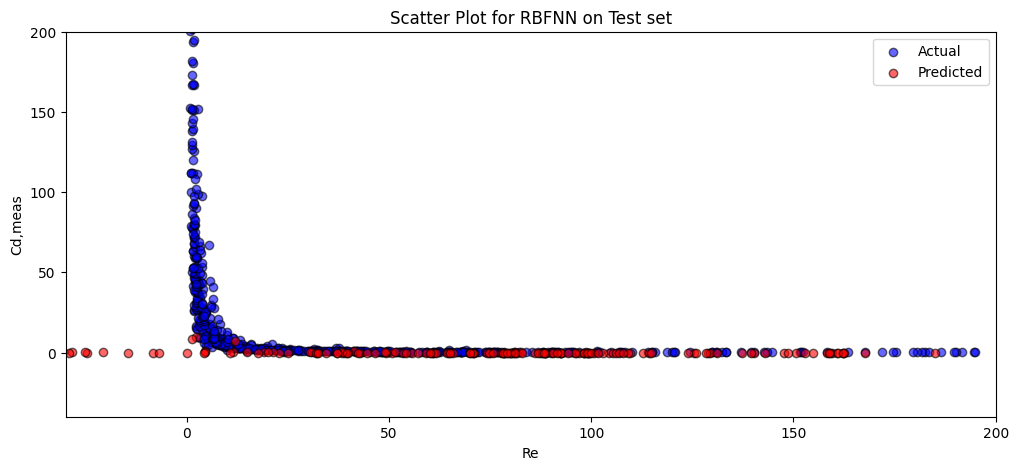

In [9]:
plt.figure(figsize=(12,5))
plt.scatter( y ,X[:,-1], c = 'blue'  ,edgecolors='black', alpha=0.6, label = 'Actual')
plt.scatter( y_pred ,X_test[:,-1], c = 'red' ,edgecolors='black', alpha=0.6, label = 'Predicted')
##plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.ylim(-40, 200)
plt.xlim(-30, 200)
plt.title('Scatter Plot for RBFNN on Test set')
plt.ylabel('Cd,meas')
plt.xlabel('Re')
plt.legend()

In [165]:
print("R-squared Score:", r2_score(y_pred ,X_test[:,-1]))

R-squared Score: -1.6587983623804599


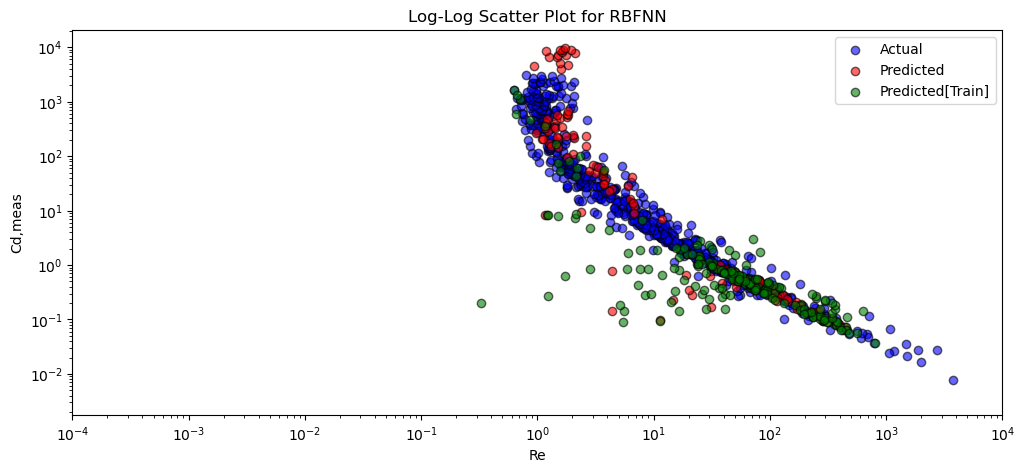

In [166]:
plt.figure(figsize=(12, 5))

plt.scatter(y, X[:, -1], c='blue',edgecolors='black', alpha=0.6, label='Actual')
plt.scatter(y_pred, X_test[:, -1], c='red',edgecolors='black', alpha=0.6, label='Predicted')
plt.scatter( y_pred_train ,X_train[:,-1], c = 'green' ,edgecolors='black', alpha=0.6, label = 'Predicted[Train]')

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.0001,10000)

plt.title('Log-Log Scatter Plot for RBFNN')
plt.ylabel('Cd,meas')
plt.xlabel('Re')
plt.legend()

plt.show()

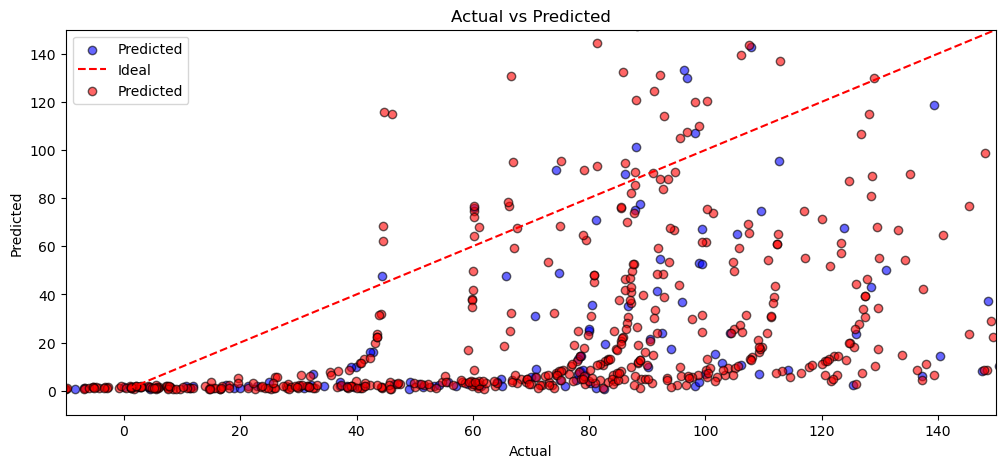

In [167]:
plt.figure(figsize=(12,5))
plt.scatter(y_pred,y_test, color='blue',edgecolors='black', alpha=0.6, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.scatter(y_pred_train,y_train, color='red',edgecolors='black', alpha=0.6, label='Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(-10, 150)
plt.ylim(-10, 150)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

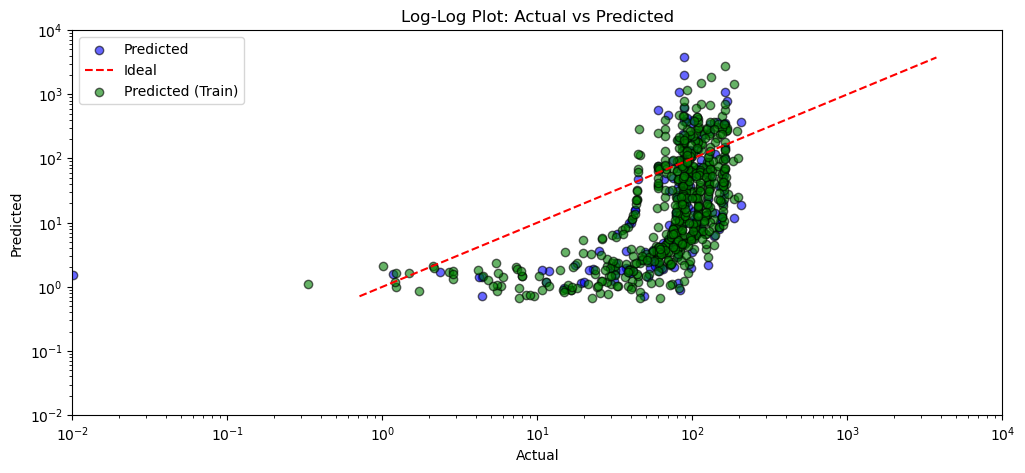

In [168]:
plt.figure(figsize=(12, 5))

plt.scatter(y_pred, y_test, color='blue',edgecolors='black', alpha=0.6, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.scatter(y_pred_train, y_train, color='green',edgecolors='black', alpha=0.6, label='Predicted (Train)')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0.01, 10000)
plt.ylim(0.01, 10000)


plt.title('Log-Log Plot: Actual vs Predicted')
plt.legend()

plt.show()

##Plotting the results of Training set

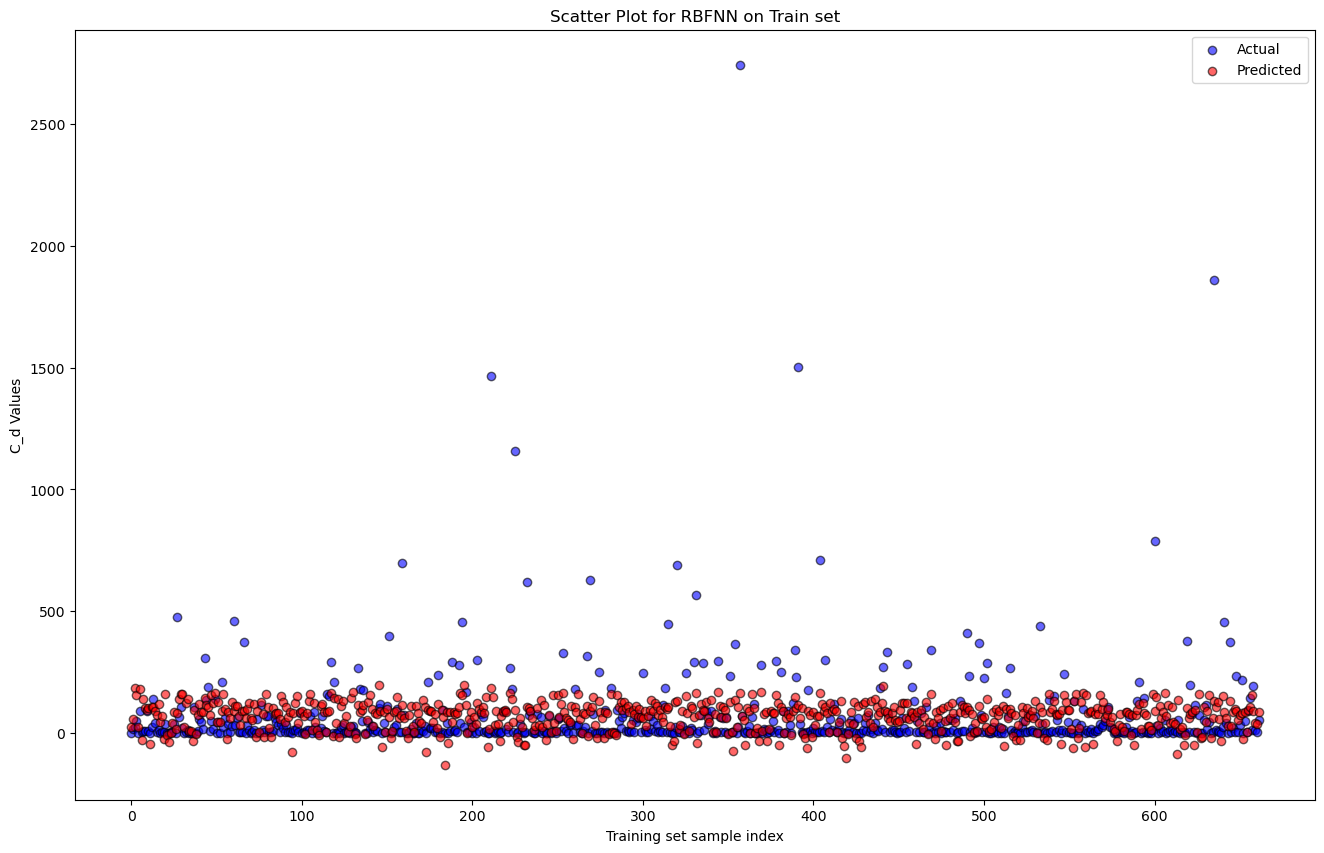

In [169]:
plt.figure(figsize=(16, 10))
plt.scatter(range(len(y_train)), y_train , c = 'blue'  ,edgecolors='black', alpha=0.6, label = 'Actual')
plt.scatter(range(len(y_pred_train)), y_pred_train , c = 'red' ,edgecolors='black', alpha=0.6, label = 'Predicted')
plt.title('Scatter Plot for RBFNN on Train set')
plt.xlabel('Training set sample index')
plt.ylabel('C_d Values')
plt.legend()
plt.show()

##Plotting the results on Testset

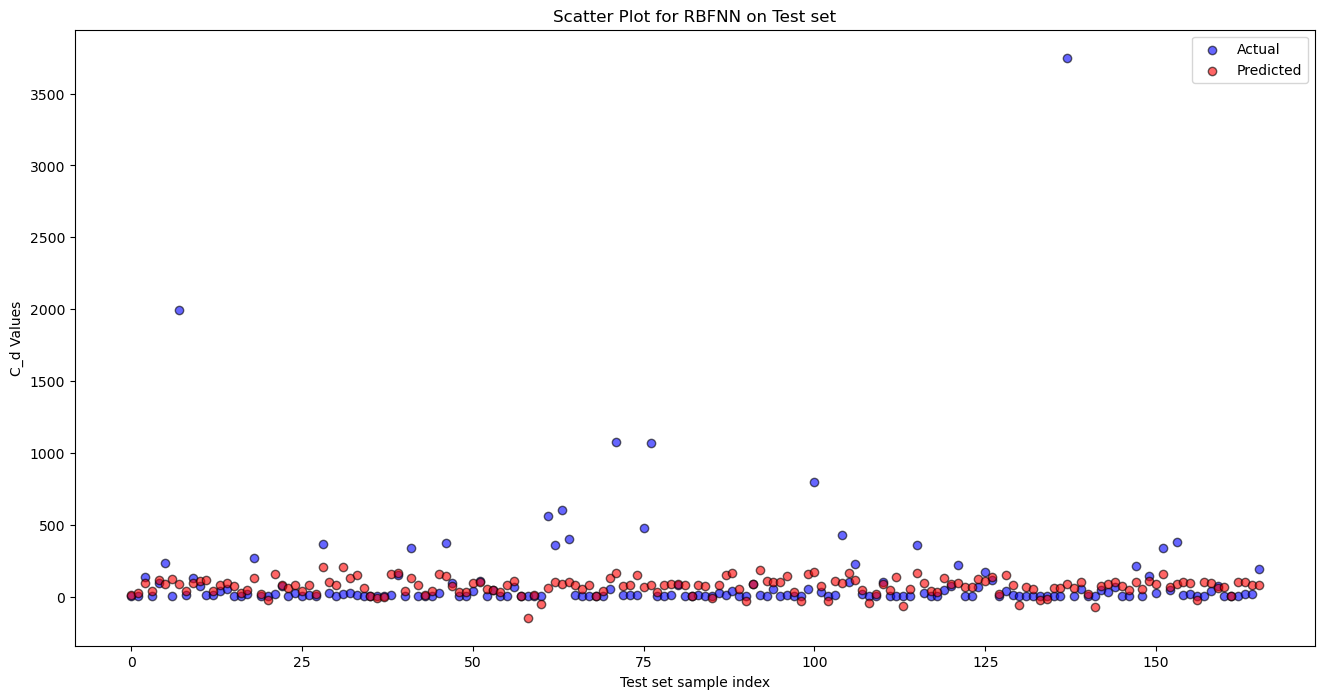

In [170]:
plt.figure(figsize=(16, 8))
plt.scatter(range(len(y_test)), y_test , c = 'blue'  ,edgecolors='black', alpha=0.6, label = 'Actual')
plt.scatter(range(len(y_pred)), y_pred , c = 'red' ,edgecolors='black', alpha=0.6, label = 'Predicted')
plt.title('Scatter Plot for RBFNN on Test set')
plt.xlabel('Test set sample index')
plt.ylabel('C_d Values')
plt.legend()
plt.show()